# Prepare Dataset

In [1]:
import os
import json
import numpy as np
import cv2

In [2]:
dataset_dir = "label_studio"
images_dir = os.path.join(dataset_dir, "images")
labeled_json = "labeled.json"

with open(os.path.join(dataset_dir, labeled_json), "r") as f:
    labeled_dict = json.load(f)

print(len(labeled_dict), labeled_dict[0])

15 {'id': 87, 'annotations': [{'id': 194, 'completed_by': 1, 'result': [{'original_width': 1622, 'original_height': 1387, 'image_rotation': 0, 'value': {'x': 4.68557336621455, 'y': 5.767844268204758, 'width': 23.79778051787916, 'height': 7.209805335255948, 'rotation': 0}, 'id': 'bb1', 'from_name': 'bbox', 'to_name': 'image', 'type': 'rectangle', 'origin': 'prediction'}, {'original_width': 1622, 'original_height': 1387, 'image_rotation': 0, 'value': {'x': 4.68557336621455, 'y': 5.767844268204758, 'width': 23.79778051787916, 'height': 7.209805335255948, 'rotation': 0, 'labels': ['Text']}, 'id': 'bb1', 'from_name': 'label', 'to_name': 'image', 'type': 'labels', 'origin': 'prediction'}, {'original_width': 1622, 'original_height': 1387, 'image_rotation': 0, 'value': {'x': 4.68557336621455, 'y': 5.767844268204758, 'width': 23.79778051787916, 'height': 7.209805335255948, 'rotation': 0, 'text': ['Komposisi:']}, 'id': 'bb1', 'from_name': 'transcription', 'to_name': 'image', 'type': 'textarea', 

In [ ]:
all_idx = list(range(len(labeled_dict)))
train_size = int(0.8 * len(labeled_dict))
train_idx = np.random.choice(all_idx, train_size, replace=False)

val_size = len(labeled_dict) - train_size
val_idx = list(set(all_idx).difference(train_idx))

print(train_idx, val_idx)
assert len(train_idx) + len(val_idx) == len(labeled_dict)

[14 12  8  1  4  9  0  5 10  2 13  3] [6, 7, 11]


In [ ]:
rec_dir = os.path.join(dataset_dir, "rec")
rec_img_dir = os.path.join(rec_dir, "images")
rec_train_txt = os.path.join(rec_dir, "train.txt")
rec_val_txt = os.path.join(rec_dir, "val.txt")

os.makedirs(rec_dir, exist_ok=True)
os.makedirs(rec_img_dir, exist_ok=True)

In [ ]:
det_dir = os.path.join(dataset_dir, "det")
det_img_dir = os.path.join(det_dir, "images")
det_train_txt = os.path.join(det_dir, "train.txt")
det_val_txt = os.path.join(det_dir, "val.txt")

os.makedirs(det_dir, exist_ok=True)
os.makedirs(det_img_dir, exist_ok=True)

In [7]:
rec_train_list = []
rec_val_list = []
det_train_list = []
det_val_list = []

for idx, d in enumerate(labeled_dict):
    split = "train" if idx in train_idx else "val"
    img_path = d["data"]["ocr"]
    img_filename = os.path.basename(img_path)
    img_rel_path = f"images/{img_filename}"
    img_full_path = os.path.join(images_dir, img_filename)
    
    img = cv2.imread(img_full_path)
    
    if img is None:
        print(f"Failed to read image: {img_full_path}")

    annt_list = d["annotations"][0]["result"]
    ori_height, ori_width = img.shape[:2]
    
    det_entries = []
    for annt_idx, annt in enumerate(annt_list):
        if annt["from_name"] != "transcription":
            continue
        
        val = annt["value"]
        x_perc, y_perc = val["x"], val["y"]
        w_perc, h_perc = val["width"], val["height"]
        text = val.get("text", "###")[0].strip()
        
        x_min = x_perc / 100 * ori_width
        y_min = y_perc / 100 * ori_height
        x_max = (x_perc + w_perc) / 100 * ori_width
        y_max = (y_perc + h_perc) / 100 * ori_height

        x_min = int(x_min)
        y_min = int(y_min)
        x_max = int(x_max)
        y_max = int(y_max)

        # Generate a quadrilateral (box)
        box = [
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max],
        ]

        img_roi = img[y_min:y_max, x_min: x_max]
        img_roi_filename = f"{split}_{idx}_{annt_idx}.png"
        img_roi_fp = os.path.join(rec_img_dir, img_roi_filename)
        
        cv2.imwrite(img_roi_fp, img_roi)
        
        det_entries.append({
            "transcription": text,
            "points": box
        })
        
        rec_line = f"images/{img_roi_filename}\t{text}"
        if split == "train":
            rec_train_list.append(rec_line)
        else:
            rec_val_list.append(rec_line)
    
    det_line = f"{img_rel_path}\t{json.dumps(det_entries, ensure_ascii=False)}"
    if split == "train":
        det_train_list.append(det_line)
    else:
        det_val_list.append(det_line)

    cv2.imwrite(os.path.join(det_dir, img_rel_path), img)

In [8]:
with open(rec_train_txt, "w", encoding="utf-8") as f:
    f.write("\n".join(rec_train_list))

with open(rec_val_txt, "w", encoding="utf-8") as f:
    f.write("\n".join(rec_val_list))

In [9]:
with open(det_train_txt, "w", encoding="utf-8") as f:
    f.write("\n".join(det_train_list))

with open(det_val_txt, "w", encoding="utf-8") as f:
    f.write("\n".join(det_val_list))

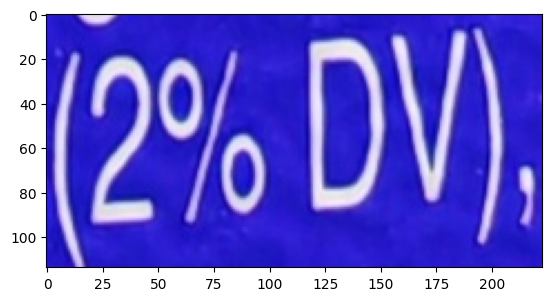

In [10]:
import matplotlib.pyplot as plt

plt.imshow(img_roi)